In [15]:
import binascii
import math
import random
import re
import string

import numpy as np

In [16]:
def invert_shingles(shingled_documents):
    # initialize list for tuples
    doc_items_pair = []
    # initialize list for document ids
    doc_ids = []
    # for each document in input
    for shingled_doc in shingled_documents:
        # append document id to list
        doc_id, items = shingled_doc
        doc_ids.append(doc_id)
        for item in items:
            # append (item, doc_id) tuple
            doc_items_pair.append((item, doc_id))
    # sort tuple list
    doc_items_pair.sort(key=lambda x: x[0])
    # return sorted tuple list, and document list
    return doc_items_pair, doc_ids

In [17]:
exclude = set(string.punctuation)


def parse_data(filename):
    ans = []
    with open("data/" + filename, "r") as f:
        # read lines from filename
        for line in f:
            if line[-1] == "\n":
                line = line[:-1]
            m = re.search(r't\d+', line)
            doc_id = m.group()
            doc = line[len(doc_id):].lower().replace(" ", "")
            doc = ''.join(ch for ch in doc if ch not in exclude)
            ans.append((doc_id, doc))
    return ans

In [18]:
def shingle_document(string, k):
    shingles_in_doc = set()
    for index in range(len(string) - k + 1):
        shingles = string[index:index + k]
        crc = binascii.crc32(bytes(shingles, encoding="utf-8"))
        shingles_in_doc.add(crc)
    return shingles_in_doc

In [19]:
def jaccard(a: set, b: set):
    # compute union size
    u = a.union(b)
    # compute intersection size
    i = a.intersection(b)
    return len(i) / len(u)


def compute_docs_JSim(filename, k):
    docs = parse_data(filename)
    doc_num = len(docs)
    ans = []
    for i in range(doc_num):
        doc_id, doc = docs[i]
        doc_shingles = shingle_document(doc, k)
        for j in range(i + 1, doc_num):
            compared_doc_id, compared_doc = docs[j]
            compared_doc_shingles = shingle_document(compared_doc, k)
            j_sim = jaccard(doc_shingles, compared_doc_shingles)
            ans.append((doc_id, compared_doc_id, j_sim))
    return ans

In [20]:
TRAIN = "articles_100.train"
TRUTH = "articles_100.truth"
K = 10

In [21]:
def get_shingled_list(docs):
    ans = []
    for doc in docs:
        doc_id, content = doc
        ans.append((doc_id, shingle_document(content, K)))
    return ans

In [22]:
def make_random_hash_fn(p=2 ** 33 - 355, m=4294967295):
    a = random.randint(1, p - 1)
    b = random.randint(0, p - 1)
    return lambda x: ((a * x + b) % p) % m


def make_hashes(num_hash):
    fns = []
    for _ in range(num_hash):
        fns.append(make_random_hash_fn())
    return fns

In [23]:
def doc_ids_column_cache(doc_ids: list):
    cache = {}
    for i, doc_id in enumerate(doc_ids):
        cache[doc_id] = i
    return cache

In [24]:
def make_minhash_signature(shingled_data, num_hashes):
    inv_index, doc_ids = invert_shingles(shingled_data)
    num_docs = len(doc_ids)

    # initialize the signature matrix with infinity in every entry
    sig_matrix = np.full([num_hashes, num_docs], np.inf)

    # generate hash functions
    hash_funcs = make_hashes(num_hashes)

    column_cache = doc_ids_column_cache(doc_ids)
    # iterate over each non-zero entry of the characteristic matrix
    for row, doc_id in inv_index:
        # update signature matrix if needed
        col = column_cache[doc_id]
        for i, hash_fn in enumerate(hash_funcs):
            sig_matrix[i][col] = min(hash_fn(row), sig_matrix[i][col])
    return sig_matrix, doc_ids

In [25]:
def minhash_similarity(id1, id2, minhash_sig_matrix, doc_ids):
    sim = 0
    column_cache = doc_ids_column_cache(doc_ids)
    # get column of the similarity matrix for the two documents
    for row in range(len(minhash_sig_matrix)):
        col1, col2 = column_cache[id1], column_cache[id2]
        # calculate the fraction of rows where two columns match
        if minhash_sig_matrix[row][col1] == minhash_sig_matrix[row][col2]:
            sim += 1
        # return this fraction as the minhash similarity estimate
    return sim / len(minhash_sig_matrix)

In [26]:
def minhash_similarity_combined(shingled_doc, num_hashes):
    minhash_sig_matrix, doc_ids = make_minhash_signature(shingled_doc, num_hashes)
    cache = doc_ids_column_cache(doc_ids)
    minhash_matrix = np.zeros((len(doc_ids), len(doc_ids)))
    ans = []
    for i in range(len(doc_ids)):
        index1 = cache[doc_ids[i]]
        for j in range(i + 1, len(doc_ids)):
            index2 = cache[doc_ids[j]]
            sim = minhash_similarity(doc_ids[i], doc_ids[j], minhash_sig_matrix, doc_ids)
            minhash_matrix[index1][index2] = sim
            ans.append((doc_ids[i], doc_ids[j], sim))
    return minhash_matrix, ans

In [27]:
def plot_jsim_minhash(train, num_hashes):
    import pandas as pd
    import matplotlib.pyplot as plt

    doc_data = parse_data(train)
    j_sim_list = compute_docs_JSim(train, K)
    js = pd.DataFrame(j_sim_list)
    js.columns = ["id1", "id2", "js"]
    shingled_list = get_shingled_list(doc_data)
    dt = []
    for k in range(1, num_hashes + 1):
        tuples = minhash_similarity_combined(shingled_list, k)[1]
        mh = pd.DataFrame(tuples)
        mh.columns = ["id1", "id2", "mh"]

        # use min squared error
        df = pd.merge(js, mh, on=["id1", "id2"])
        df["diff"] = (df.js - df.mh) ** 2
        mse = df["diff"].sum()
        rmse = math.sqrt(mse / len(df))
        fraction = np.mean(js.js == mh.mh)
        num = k
        dt.append((num, rmse, fraction))
    dt = pd.DataFrame(dt, columns=["num", "rmse", "fraction"])
    plt.plot(dt.num, dt.rmse, color="blue")
    plt.title("RMSE of Jaccard Similarity and MinHash Similarity")
    plt.xlabel("Number of Hash Functions")
    plt.ylabel("Root Mean Squared Error")
    plt.show()

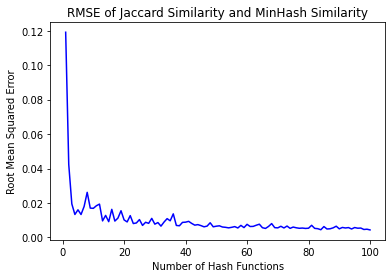

In [28]:
plot_jsim_minhash(TRAIN, 100)